In [56]:
# import libraries
import pandas as pd
import psycopg2
import datetime
from datetime import datetime, timedelta
from random import randint
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
# connect to database
conn = psycopg2.connect(database = "fairatmos_assessment", 
                        user = "postgres", 
                        host= '127.0.0.1',
                        password = "password",
                        port = 5432)

In [58]:
# Open a cursor to perform database operations
cur = conn.cursor()

query = """ CREATE TABLE IF NOT EXISTS user_table (
            user_id SERIAL PRIMARY KEY,
            signup_date TIMESTAMP NOT NULL)
        """

# Execute a command: create user_table table if it doesn't exist
cur.execute(query)
# Make the changes to the database persistent
conn.commit()
# Close cursor and communication with the database
cur.close()


In [59]:
cur = conn.cursor()

query = """ CREATE TABLE IF NOT EXISTS order_table (
            order_id SERIAL PRIMARY KEY,
            user_id INT REFERENCES user_table(user_id),
            transaction_date TIMESTAMP)
        """

cur.execute(query)

conn.commit()
cur.close()

Create dummy data for 4 month in 2023

In [60]:
# insert dummy data to user_table
cur = conn.cursor()
start_date = datetime(2023, 1, 1)

for i in range(100):
    # insert signup_date 
    signup_date = start_date + timedelta(days=i)

    # write sql statement to insert data to user_table
    query = "INSERT INTO user_table (signup_date) VALUES (%s)"

    cur.execute(query, (signup_date,))

conn.commit()
cur.close()

In [61]:
# insert dummy data to order_table
cur = conn.cursor()

start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 4, 15)

# Function to generate a random date within a specified range
def random_date(start_date, end_date):
    return start_date + timedelta(days=randint(0, (end_date - start_date).days))

for i in range(100):
    transaction_date = random_date(start_date, end_date)
    user_id = randint(1, 100)
    insert_query = "INSERT INTO order_table (user_id, transaction_date) VALUES (%s, %s)"
    cur.execute(insert_query, (user_id, transaction_date))

conn.commit()
cur.close()

- Monthly Signups

In [62]:
cur = conn.cursor()

# this query will return the number of users who signed up in each month
query = """ SELECT TO_CHAR(signup_date, 'YYYY-MM') AS signup_month, COUNT(*) AS signup_count
            FROM user_table
            GROUP BY TO_CHAR(signup_date, 'YYYY-MM')
            ORDER BY TO_CHAR(signup_date, 'YYYY-MM');
        """

# Execute the SQL query
cur.execute(query)

# Fetch all the rows as a list of tuples
result = cur.fetchall()
conn.commit()
cur.close()

In [63]:
# Convert into DataFrame
user_df = pd.DataFrame(result, columns=['signup_month', 'signup_count'])
user_df

,signup_month,signup_count
0,2023-01,31
1,2023-02,28
2,2023-03,31
3,2023-04,10


In [64]:
# convert format of signup_month to month name
user_df['signup_month'] = pd.to_datetime(user_df['signup_month'], format='%Y-%m').dt.month_name()

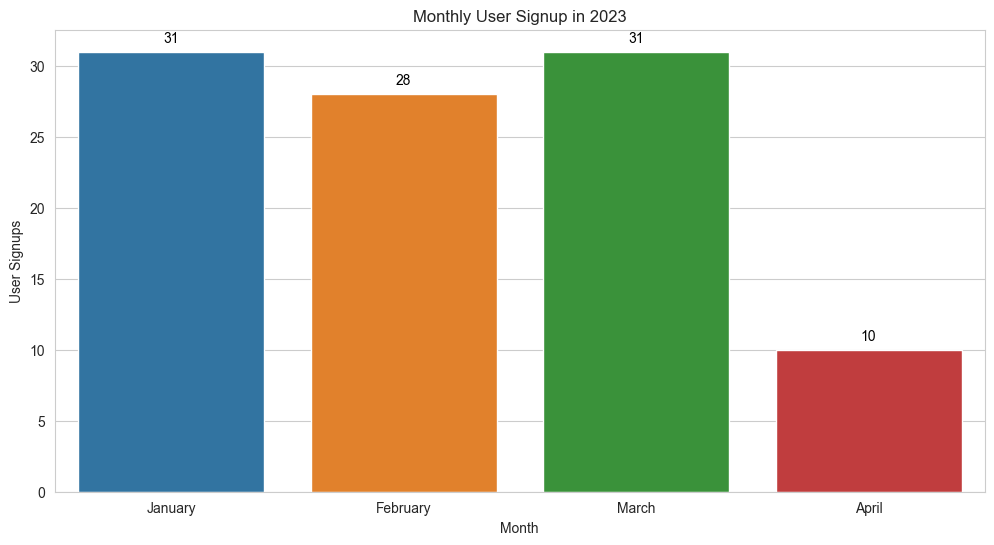

In [65]:
# create a bar plot 
sns.set_style('whitegrid')
plt.figure(figsize=(12, 6))
plt.title('Monthly User Signup in 2023')

ax = sns.barplot(x='signup_month', y='signup_count', data=user_df)

# add labels to each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.xlabel('Month')
plt.ylabel('User Signups')
plt.show()


- Monthly Conversion

In [66]:
cur = conn.cursor()

# this query will return conversion rate of each month
query = """
WITH q1 AS (
    SELECT
        TO_CHAR(u.signup_date, 'YYYY-MM') AS month,
        COUNT(u.user_id) AS user_count
    FROM user_table u
    RIGHT JOIN order_table o ON u.user_id = o.user_id
    WHERE TO_CHAR(u.signup_date, 'YYYY-MM') = TO_CHAR(o.transaction_date, 'YYYY-MM')
    GROUP BY month
),
q2 AS (
    SELECT TO_CHAR(signup_date, 'YYYY-MM') AS month, COUNT(DISTINCT user_id) AS user_count
    FROM user_table
    GROUP BY TO_CHAR(signup_date, 'YYYY-MM')
)
SELECT
    q1.month,
    CASE
        WHEN COALESCE(q1.user_count, 0) = 0 THEN 0.00
        ELSE (CAST(q1.user_count AS numeric) / CAST(q2.user_count AS numeric) * 100)::numeric(10,2)
    END AS conversion_rate
FROM q1
FULL JOIN q2 ON q1.month = q2.month
ORDER BY q1.month;
"""

cur.execute(query)

result = cur.fetchall()

conn.commit()
cur.close()

In [67]:
merged_df = pd.DataFrame(result, columns=['month','conversion_rate'])
# convert format of signup_month to month name
merged_df['month'] = pd.to_datetime(merged_df['month'], format='%Y-%m').dt.month_name()
merged_df

,month,conversion_rate
0,January,38.71
1,February,32.14
2,March,29.03
3,April,20.00


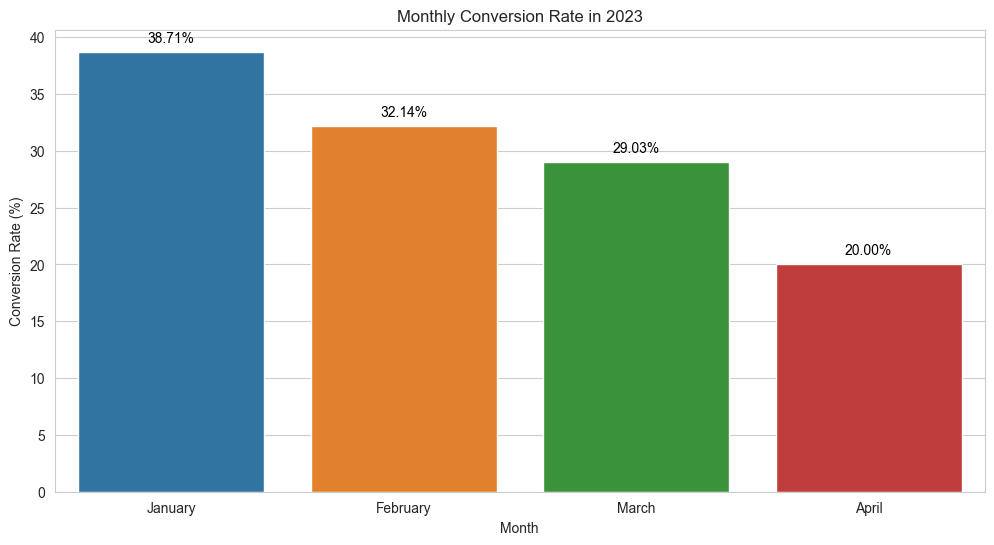

In [68]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 6))
plt.title('Monthly Conversion Rate in 2023')

ax = sns.barplot(x='month', y='conversion_rate', data=merged_df)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.xlabel('Month')
plt.ylabel('Conversion Rate (%)')
plt.show()
